# Dataset link to download in colab

In [1]:
!gdown --id "1bSZV_fzH8FP007DZI01BZiBVjExyvHKc"

Downloading...
From: https://drive.google.com/uc?id=1bSZV_fzH8FP007DZI01BZiBVjExyvHKc
To: /content/indian_currency_new.tar.xz
157MB [00:01, 154MB/s]


In [2]:
!ls

indian_currency_new.tar.xz  sample_data


In [3]:
import tarfile
import os
import shutil

In [4]:
with tarfile.open('indian_currency_new.tar.xz') as f:
  f.extractall('.')

In [5]:
!ls

indian_currency_new  indian_currency_new.tar.xz  sample_data


In [6]:
DIR = './indian_currency_new'

In [7]:
!mkdir ./indian_currency_new/testing

In [8]:
SRC = DIR + '/validation'
DST = DIR + '/testing'

In [9]:
!rm -r ./indian_currency_new/training/Background
!rm -r ./indian_currency_new/validation/Background

# **Generating a Test and Validation Dataset**

In [10]:
for folder, subfolders, filenames in os.walk(SRC):
  if folder != SRC:
    name = folder.split('/')[-1]
    src_path = os.path.join(SRC, name)
    dst_path = os.path.join(DST, name)
    print(f'Current folder :{folder}\n')
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file_ in filenames[len(filenames) // 2 :]:
      shutil.move(os.path.join(src_path, file_), dst_path)

Current folder :./indian_currency_new/validation/10

Current folder :./indian_currency_new/validation/50

Current folder :./indian_currency_new/validation/500

Current folder :./indian_currency_new/validation/200

Current folder :./indian_currency_new/validation/20

Current folder :./indian_currency_new/validation/100

Current folder :./indian_currency_new/validation/2000



# Training

In [11]:
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':  
    raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name)) 

Found GPU at: /device:GPU:0


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random

# Visulizing data.

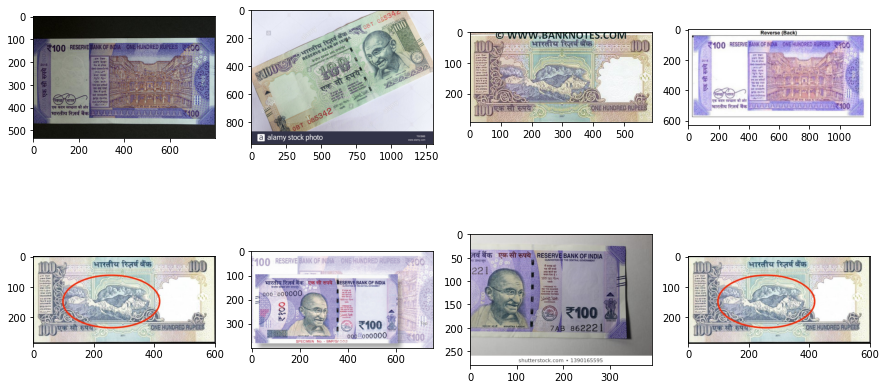

In [13]:
img_path_100 = DIR + '/training/100'
img_names = os.listdir(img_path_100)
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(2):
  for j in range(4):
    img_name = random.choice(img_names)
    img = plt.imread(img_path_100 + '/' + img_name)
    ax[i][j].imshow(img)

# Parameters

In [14]:
TRAINING_DATA_PATH = DIR + '/training'
IMG_SIZE = (250, 500)
NUM_CLASSES = 7
VALID_DATA_DIR = DIR + '/validation'
BATCH_SIZE = 6
NUM_EPOCH = 15
FREEZE_LAYERS = 16 
LEARNING_RATE = 0.0002
DROP_OUT = .2



# **Loading a model**

In [15]:
model = Xception(include_top = False,
              weights = 'imagenet',
              input_tensor = None,
              input_shape = (250, 500, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [16]:
'''
model = InceptionResNetV2(include_top = False,
                          weights = 'imagenet',
                          input_tensor = None,
                          input_shape = (250, 500, 3))
'''

"\nmodel = InceptionResNetV2(include_top = False,\n                          weights = 'imagenet',\n                          input_tensor = None,\n                          input_shape = (250, 500, 3))\n"

In [17]:
top_layer = model.output
x = GlobalAveragePooling2D()(top_layer)
op = Dense(NUM_CLASSES, activation = 'softmax', name = 'softmax')(x)
model_final = Model(inputs = model.input, outputs = op)

In [18]:
for layer in model_final.layers[:FREEZE_LAYERS]:
  layer.trainable = False

for layer in model_final.layers[FREEZE_LAYERS:]:
  layer.trainable = True

In [19]:
model_final.compile(optimizer = Adam(lr = LEARNING_RATE),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [20]:
print(model_final.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 249, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 249, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [21]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [22]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [23]:
train_batches = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )


Found 543 images belonging to 7 classes.


In [24]:
valid_batches = train_datagen.flow_from_directory(VALID_DATA_DIR,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 78 images belonging to 7 classes.


In [25]:
class_dictionary = train_batches.class_indices
class_dictionary

{'10': 0, '100': 1, '20': 2, '200': 3, '2000': 4, '50': 5, '500': 6}

In [26]:
checkpoint = ModelCheckpoint('Xception_model.h5', monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, save_weights_only = False,
                             mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10,
                      verbose = 1, mode = 'auto')

In [27]:
model_final.fit_generator(train_batches,
                          steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                          validation_data = valid_batches,
                          validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                          epochs = NUM_EPOCH,
                          callbacks = [checkpoint, early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 1.8794 - accuracy: 0.3021
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to Xception_model.h5
16/16 [==============================] - 6s 400ms/step - loss: 1.8794 - accuracy: 0.3021 - val_loss: 1.7835 - val_accuracy: 0.3333
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.4274 - accuracy: 0.5376
Epoch 00002: val_accuracy improved from 0.33333 to 0.50000, saving model to Xception_model.h5
16/16 [==============================] - 6s 381ms/step - loss: 1.4274 - accuracy: 0.5376 - val_loss: 1.4397 - val_accuracy: 0.5000
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.6667
Epoch 00003: val_accuracy improved from 0.50000 to 0.72222, saving model to Xception_model.h5
16/16 [==============================] - 6s 371ms/step - loss: 1.0548 - accuracy: 0.6667 - val_loss: 

In [28]:
test_categories = os.listdir(DST)

In [29]:
class_dictionary

{'10': 0, '100': 1, '20': 2, '200': 3, '2000': 4, '50': 5, '500': 6}

In [30]:
vals = list(class_dictionary.values())
keys = list(class_dictionary.keys())

# **Predicting on Test dataset**

In [31]:
for p in test_categories:
  sum_confidence = 0.
  print(f'Predicting on the class {p}')
  for img_name in os.listdir(os.path.join(DST, p)):
    img = image.load_img(DST + '/' + p  + '/' + img_name, target_size = IMG_SIZE)
    array = image.img_to_array(img)
    test_image = np.expand_dims(array, axis = 0)
    test_image = preprocess_input(test_image)
    prediction = model_final.predict(test_image)
    idx = np.argmax(prediction, axis = 1)
    confidence = prediction[0, idx] * 100
    digit = keys[vals.index(idx)]
    print(f'Model predict digit {digit} for image {img_name} with confidence {confidence[0]}')
    sum_confidence += confidence
  avg_confidence = sum_confidence / len(os.listdir(os.path.join(DST, p)))
  print(f'Average confidence on class {p} is {avg_confidence}')


Predicting on the class 10
Model predict digit 10 for image 54.jpg with confidence 99.99322509765625
Model predict digit 10 for image 50.jpg with confidence 99.99431610107422
Model predict digit 10 for image 48.jpg with confidence 98.91188049316406
Model predict digit 10 for image 52.jpg with confidence 99.84864807128906
Model predict digit 200 for image 53.jpg with confidence 37.20317077636719
Model predict digit 10 for image 57.jpg with confidence 99.99576568603516
Model predict digit 10 for image 37.jpg with confidence 99.5144271850586
Model predict digit 10 for image 43.jpg with confidence 99.8635482788086
Model predict digit 10 for image 40.jpg with confidence 98.31794738769531
Average confidence on class 10 is [92.62698]
Predicting on the class 50
Model predict digit 50 for image 18.jpg with confidence 99.47683715820312
Model predict digit 50 for image 6.jpg with confidence 99.70298767089844
Model predict digit 50 for image 17.jpg with confidence 99.0186538696289
Model predict di

In [32]:
!ls

indian_currency_new  indian_currency_new.tar.xz  sample_data  Xception_model.h5


In [33]:
!ls -l

total 397568
drwxrwxr-x 5 1000 1000      4096 Oct 19 04:59 indian_currency_new
-rw-r--r-- 1 root root 156748092 Oct 19 04:59 indian_currency_new.tar.xz
drwxr-xr-x 1 root root      4096 Oct 14 16:31 sample_data
-rw-r--r-- 1 root root 250349200 Oct 19 05:01 Xception_model.h5
